In [1]:
# Code modified from Charlie's masters student

import os
import cv2
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob
from tqdm import tqdm

In [2]:
torch.cuda.is_available()

True

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [4]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [8]:
wing_1 = Image.open('../testdata/optimized/043870_L_O.JPG')
wing_2 = Image.open('../testdata/optimized/043870_R_O.JPG')
wing_3 = Image.open('../testdata/optimized/043874_L_O.JPG')
wing_4 = Image.open('../testdata/optimized/043874_R_O.JPG')
wing_5 = Image.open('../testdata/optimized/043878_L_O.JPG')
wing_6 = Image.open('../testdata/optimized/043878_R_O.JPG')
wing_7 = Image.open('../testdata/optimized/043884_L_O.JPG')

wing = wing_2
wing = np.array(wing.convert("RGB"))

In [9]:
wing.shape
# scale_percent = 0.30 
# new_width = int(wing.shape[1] * scale_percent)
# new_height = int(wing.shape[0] * scale_percent)
# wing = cv2.resize(wing, (new_width, new_height))

(1756, 2641, 3)

In [5]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


sam2_checkpoint = "sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [7]:
glob('../1_slides/2_individual_wings/Hive01*slide5_*.png')

['../1_slides/2_individual_wings/Hive01_Sheet_01_slide5_right.png',
 '../1_slides/2_individual_wings/Hive01_Sheet_01_slide5_left.png']

  0%|                                                                                                                                                                               | 0/4510 [00:00<?, ?it/s]

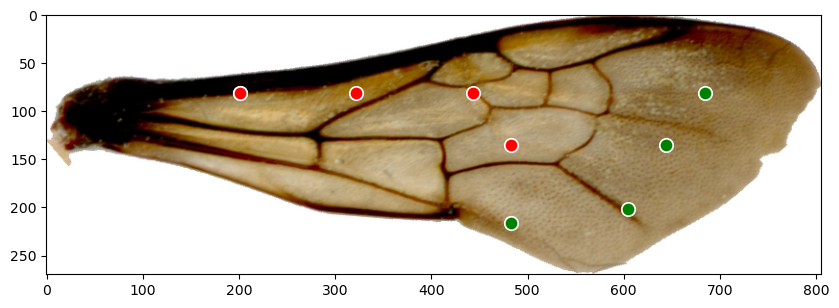

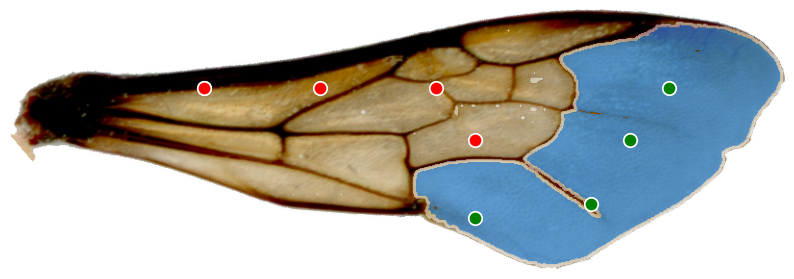

  0%|                                                                                                                                                                               | 0/4510 [00:01<?, ?it/s]


In [8]:
# Big cell segmentation
DEBUG = True

fps = glob('../1_slides/2_individual_wings/*.png')
np.random.shuffle(fps)
for fp in tqdm(fps):
    if DEBUG:
        fp = '../1_slides/2_individual_wings/Hive01_Sheet_01_slide5_right.png'
    wing_name = fp.split('/')[-1].split('.')[0]
    wing = cv2.imread(fp)
    wing = cv2.cvtColor(wing, cv2.COLOR_BGR2RGB)


    predictor.set_image(wing)
    width = wing.shape[1]
    height = wing.shape[0]
    
    input_points = np.array([[3*width//5, height//2], 
                             [int(0.55*width), int(0.3*height)],
                             [int(0.25*width), int(0.3*height)],
                             [int(0.4*width), int(0.3*height)],
                             [int(0.25*width), int(0.3*height)],
                             
                             [int(0.85*width), int(0.3*height)],
                             [4*width//5, height//2], 
                             [3*width//5, 4*height//5], 
                             [int(0.75*width), int(0.75*height)]])
    input_labels = np.array([0,0,0,0,0, 1, 1, 1,1])
    if DEBUG:
        plt.figure(figsize=(10, 10))
        plt.imshow(wing)
        show_points(input_points, input_labels, plt.gca())
    
        plt.show()  

    mask, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        multimask_output=True,
    )
    sorted_ind = np.argsort(scores)[::-1]
    mask = mask[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    
    if DEBUG:
        show_masks(wing, [mask[0]], [scores[0]], point_coords=input_points, input_labels=input_labels)
    mask_fp = '../slides/3_sam_masks_big_cell/' + wing_name + '.png'
    

    if DEBUG:
        break
    else:
        cv2.imwrite(mask_fp, mask[0]*255)
        

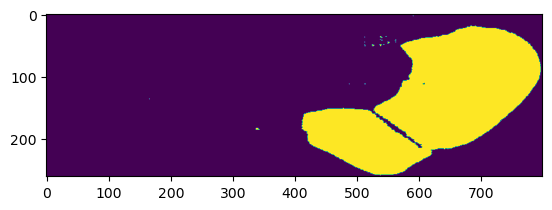

In [101]:
plt.imshow(mask[0])

In [10]:
# sub medial cell segmentation
for fp in tqdm(fps):
    wing_name = fp.split('/')[-1].split('.')[0]
    wing = cv2.imread(fp)
    wing = cv2.cvtColor(wing, cv2.COLOR_BGR2RGB)
    
    
    predictor.set_image(wing)
    width = wing.shape[1]
    height = wing.shape[0]
    
    input_points = np.array([[3*width//5, height//2], 
                             [int(0.55*width), int(0.5*height)],
                             [int(0.65*width), int(0.45*height)],
                             
                             [int(0.55*width), int(0.3*height)],
                             [int(0.25*width), int(0.3*height)],
                             [int(0.4*width), int(0.3*height)],
                             [int(0.85*width), int(0.3*height)]])
    input_labels = np.array([1,1,1,0,0,0, 0])
    #plt.figure(figsize=(10, 10))
    #plt.imshow(wing)
    #show_points(input_points, input_labels, plt.gca())
    
    #plt.show()  
    mask, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
    )
    sorted_ind = np.argsort(scores)[::-1]
    mask = mask[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    #show_masks(wing, [mask[0]], [scores[0]], point_coords=input_points, input_labels=input_labels)
    mask_fp = '../slides/3_sam_masks_medial/' + wing_name + '.png'
    cv2.imwrite(mask_fp, mask[0]*255)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4020/4020 [41:07<00:00,  1.63it/s]


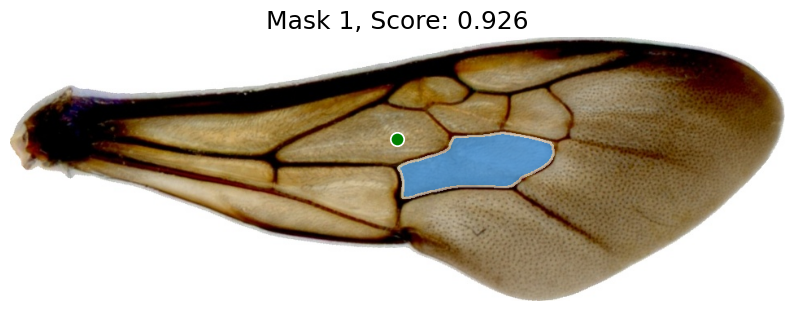

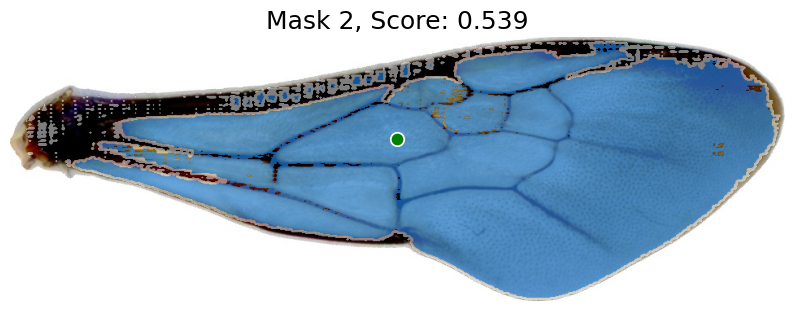

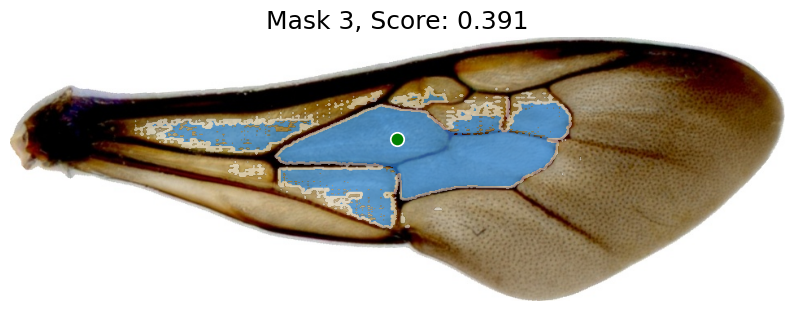

In [136]:
mask, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
mask = mask[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]
show_masks(wing, mask, scores, point_coords=input_point, input_labels=input_label)
#mask_fp = '../slides/3_sam_masks/' + wing_name + '_bigcell.jpg'
#cv2.imwrite(mask_fp, mask[0])

In [12]:
mask2 = mask.squeeze()  # Removes the extra dimension if it's size 1
new_image = mask2[..., None] * wing  # Add an axis to the mask to match the image's shape
new_image = new_image.astype('uint8')

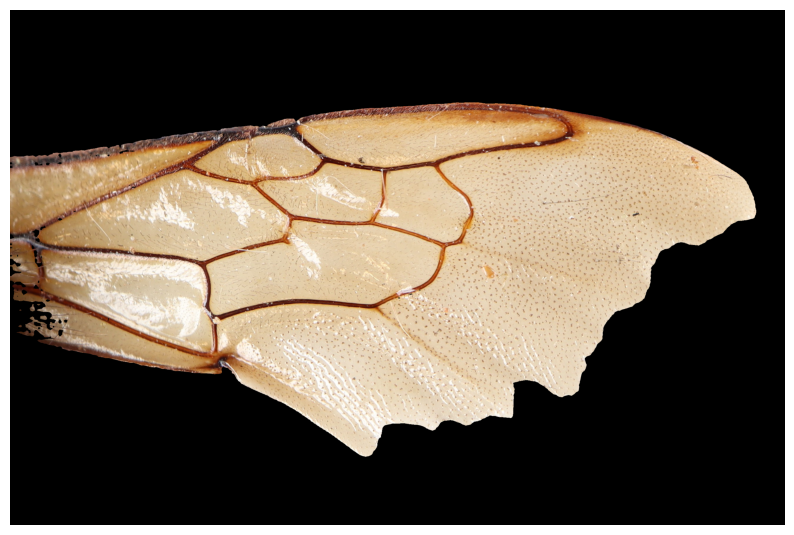

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(new_image)
plt.axis('off')
plt.show()  

In [14]:
new_image.shape

(1756, 2641, 3)

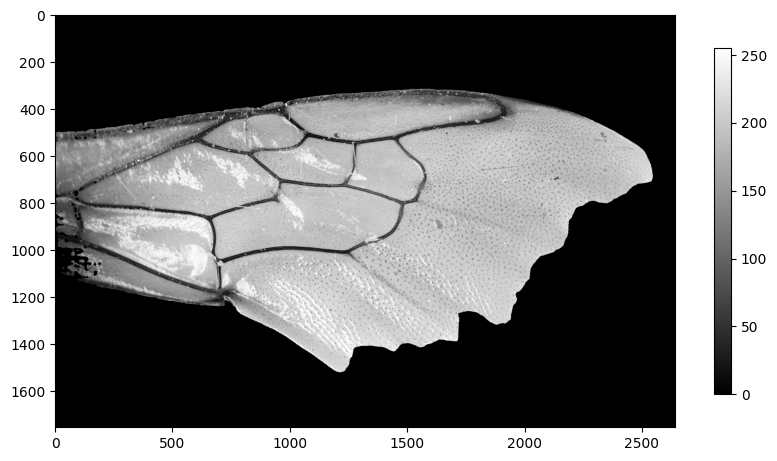

In [15]:
gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 10))
plt.imshow(gray, cmap='gray')
plt.colorbar(shrink=0.45)
plt.axis('on')
plt.show()

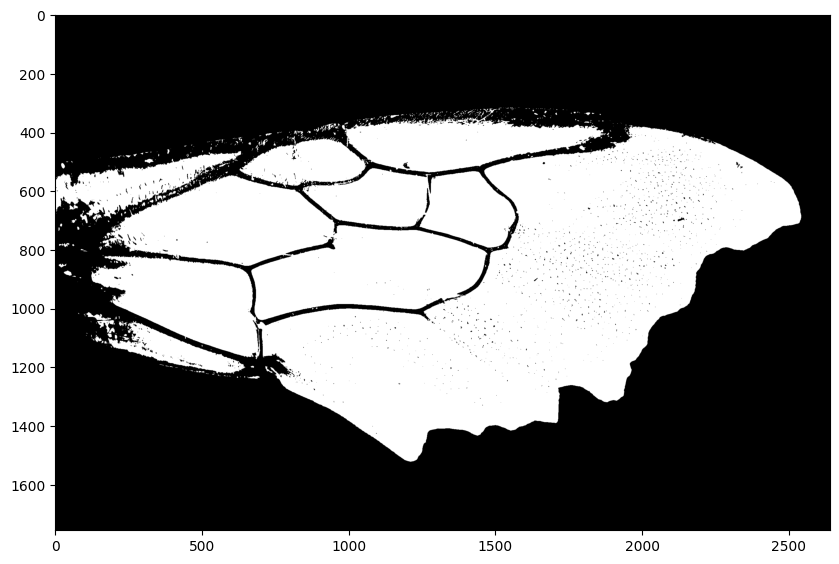

In [16]:
_, binary_image = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY)

# binary_image = binary_image * 255

plt.figure(figsize=(10, 10))
plt.imshow(binary_image, cmap='gray')
plt.axis('on')
plt.show()

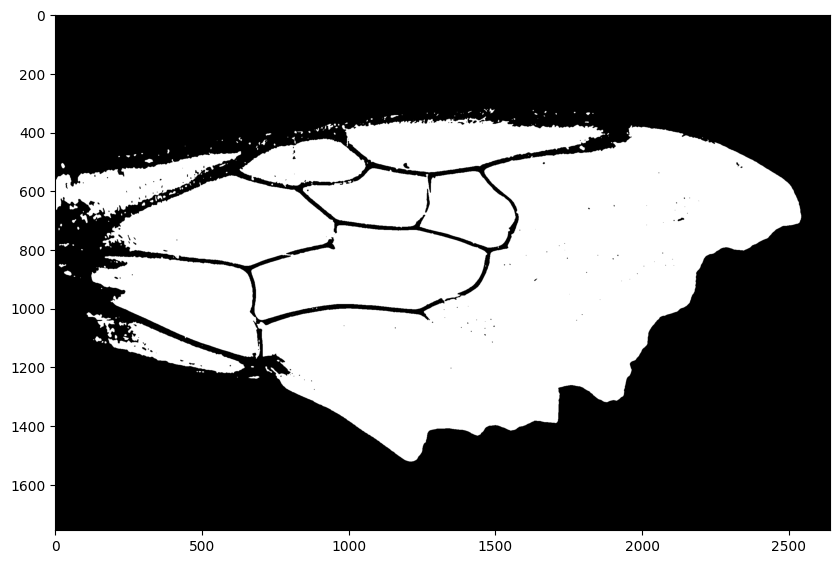

In [17]:
# wing_denoised = cv2.GaussianBlur(resized_wing, (5, 5), 0)
blurred = cv2.medianBlur(binary_image, 5)

plt.figure(figsize=(10, 10))
plt.imshow(blurred, cmap='gray')
plt.axis('on')
plt.show()

In [18]:
# scale_percent = 0.20 
# new_width = int(gray.shape[1] * scale_percent)
# new_height = int(gray.shape[0] * scale_percent)
# resized_wing = cv2.resize(binary_image, (new_width, new_height))
# plt.figure(figsize=(10, 10))
# plt.imshow(resized_wing, cmap='gray')
# plt.show()

In [19]:
binary_rgb = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)

In [20]:
cv2.imwrite('../testdata/output/binary_1.jpg', binary_rgb)

True

In [21]:
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import time
start = time.time()

sam2_checkpoint = "/home/wsl/bin/segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

masks_2 = mask_generator.generate(binary_rgb)

end = time.time()
print(round(end - start, 2), "seconds")

20.51 seconds


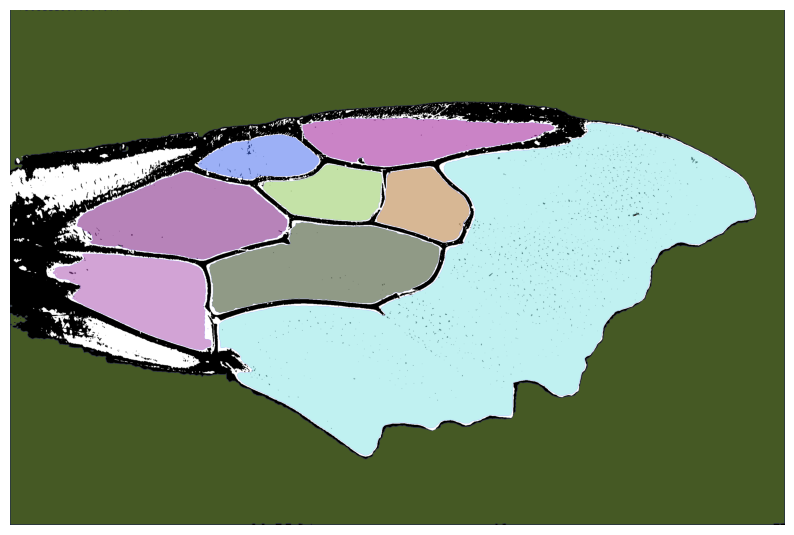

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(binary_rgb)
show_anns(masks_2)
plt.axis('off')
plt.savefig('../testdata/output/segmented_1.jpg')
plt.show()

In [39]:
for i, mask in enumerate(masks_2):
    print(f"Size of label {i}:\t{mask['area']} pixels")

Size of label 0:	2578251 pixels
Size of label 1:	55231 pixels
Size of label 2:	55706 pixels
Size of label 3:	55805 pixels
Size of label 4:	163758 pixels
Size of label 5:	43707 pixels
Size of label 6:	140292 pixels
Size of label 7:	110328 pixels
Size of label 8:	94240 pixels
Size of label 9:	923873 pixels


In [40]:
max_area = 0
largest_label = None

for data in masks_2:
    if data['area'] > max_area:
        max_area = data['area']
        largest_label = data
        
masks_2 = [data for data in masks_2 if data['area'] != max_area]

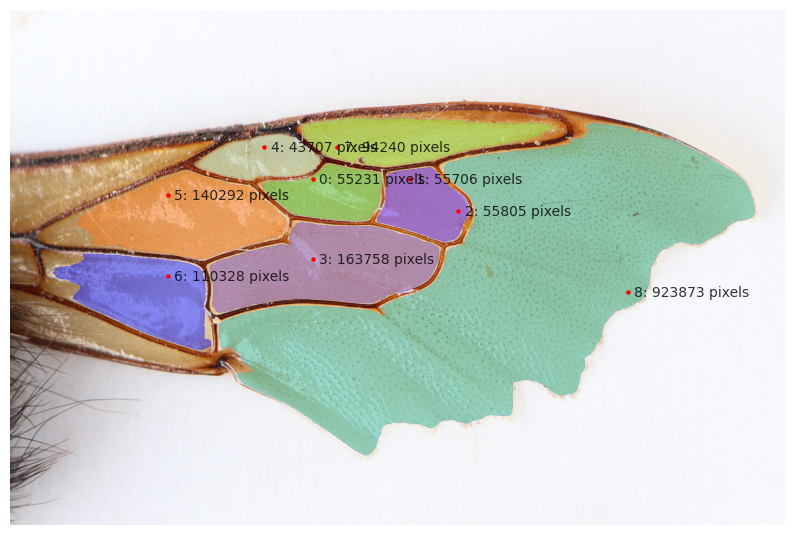

In [41]:
plt.figure(figsize=(10, 10))
plt.imshow(wing, cmap='gray')
show_anns(masks_2)
for i, label in enumerate(masks_2):
    point = label['point_coords'][0]
    text = str(i) + ": " + str(label['area']) + " pixels"
    plt.scatter(point[0], point[1], color='red', s=5)
    plt.text(point[0] + 22, point[1] + 16, text, alpha=0.8)
plt.axis('off')
plt.savefig('../testdata/output/segmented_2.jpg')
plt.show()